In [ ]:
import numpy as np
import pandas as pd
import time as tm
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def my_map( X ):
  X = np.flip(np.cumprod(np.flip(2 * X - 1, axis = 1), axis = 1), axis = 1)
  X = np.hstack((X, np.ones((X.shape[0], 1))))
  num_columns = X.shape[1]
  feat = np.empty((X.shape[0], num_columns * (num_columns + 1) // 2))
  idx = 0

  for i in range(num_columns):
      feat[:, idx:idx+num_columns-i] = X[:, i:] * X[:, i][:, np.newaxis]
      idx += num_columns - i

  return feat

In [ ]:
def my_fit_logistic(X_train, y_train, C):
    features = my_map(X_train)
    labels = y_train
    features = StandardScaler().fit_transform(features)
    model = LogisticRegression(C = C)
    model.fit(features, labels)
    w = model.coef_.flatten()
    b = model.intercept_[0]

    return w,b

In [ ]:
def my_fit_svc(X_train, y_train, C):
	features = my_map(X_train)
	labels = y_train
	features = StandardScaler().fit_transform(features)
	model = LinearSVC(penalty='l1', dual=False)
	model.fit(features, labels)
	w = model.coef_.flatten()
	b = model.intercept_[0]

	return w,b

In [ ]:
Z_trn = np.loadtxt( "secret_train.dat" )
Z_tst = np.loadtxt( "secret_test.dat" )

In [ ]:
n_trials = 5

In [ ]:
C_values = ['l1', 'l2']
svc_df_C_acc = pd.DataFrame(
    data = np.zeros([n_trials, len(C_values)]),
    columns = C_values
)
svc_df_C_t_train = pd.DataFrame(
    data = np.zeros([n_trials, len(C_values)]),
    columns = C_values
)

In [ ]:
for iter in range(1, n_trials+1):
    print(f'iter{iter}')
    for C in svc_df_C_acc.columns:

        d_size = 0
        t_train = 0
        t_map = 0
        acc = 0

        tic = tm.perf_counter()
        w, b = my_fit_svc(Z_trn[:, :-1], Z_trn[:,-1], C)
        toc = tm.perf_counter()
        t_train += toc - tic

        d_size += w.shape[0]

        tic = tm.perf_counter()
        feat = my_map( Z_tst[:, :-1] )
        toc = tm.perf_counter()
        t_map += toc - tic

        scores = feat.dot( w ) + b
        pred = np.zeros_like( scores )
        pred[scores > 0] = 1
        acc += np.average( Z_tst[ :, -1 ] == pred )

        print("trained!")

        svc_df_C_acc.at[iter,C] = acc
        svc_df_C_t_train.at[iter, C] = t_train



In [ ]:
svc_df_C_t_train.shape

(6, 5)

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple']

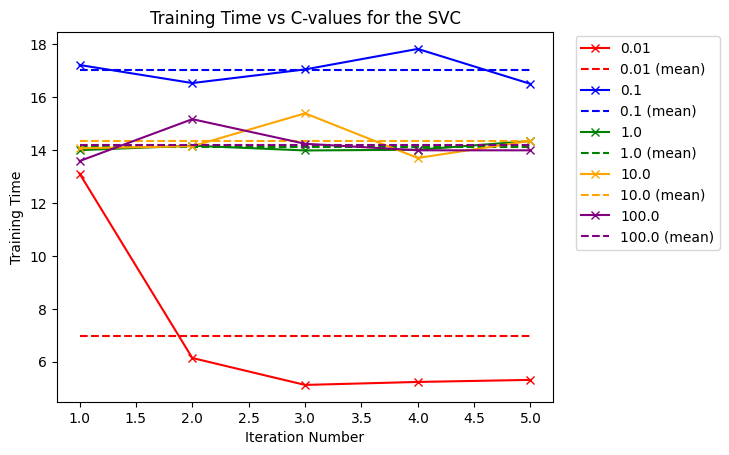

In [ ]:

for i in range(len(C_values)):
    plt.plot(range(1, n_trials+1), svc_df_C_t_train.iloc[1:,:][C_values[i]], marker = 'x', label = f'{C_values[i]}', color = colors[i])
    plt.plot(range(1, n_trials+1), [svc_df_C_t_train.iloc[1:,:][C_values[i]].mean() for _ in range(1, n_trials+1)], linestyle = '--', label = f'{C_values[i]} (mean)', color=colors[i])

plt.title('Training Time vs C-values for the SVC')
plt.xlabel('Iteration Number')
plt.ylabel('Training Time')

plt.legend(loc='center right' , bbox_to_anchor=(1.35, 0.7))
plt.savefig('t_train_C_svm.jpg')
plt.savefig('t_train_C_svm.png')
plt.show()

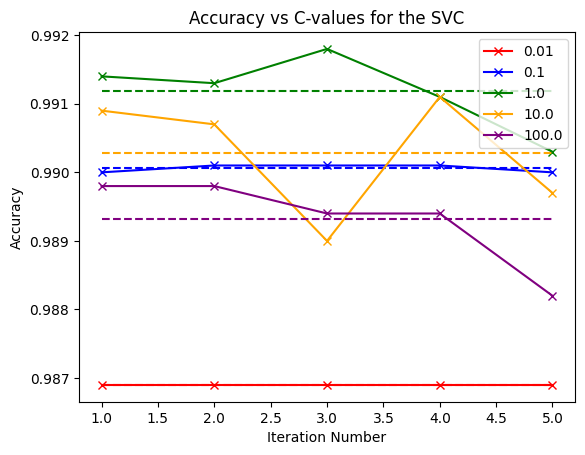

In [ ]:

for i in range(len(C_values)):
    plt.plot(range(1, n_trials+1), svc_df_C_acc.iloc[1:,:][C_values[i]], marker = 'x', label = f'{C_values[i]}', color = colors[i])
    plt.plot(range(1, n_trials+1), [svc_df_C_acc.iloc[1:,:][C_values[i]].mean() for _ in range(1, n_trials+1)], linestyle = '--', color=colors[i])

plt.title('Accuracy vs C-values for the SVC')
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig('accuracy_C_svm.jpg')
plt.savefig('accuracy_C_svm.png')
plt.show()